In [2]:
Arch='FF'
num_layers=3
sizeof_layers=92
batch_norm=True
Ext='-c'
kl_anneal=0.2256517543235762
rho_q=1.655347975507712
rho_op=1.0372322886375782
prior_scale=8.98259424445624
sizeof_bnn=10
Batch_Size=98
Epochs=134
Gamma=0
country='us'
early_stopping=False
smooth=True

best = {'Batch_Size': 41.96748457321958,
  'Epochs': 424.3437436729439,
  'kl_anneal': 1.5964390315705428,
  'lr': 0.003417591943416138,
  'num_layers': 2.210547886253363,
  'prior_scale': 6.036282385114858,
  'rho_op': 9.298299473356227,
  'rho_q': 4.327971705268932,
  'scheduler_exp_val': -0.018715030006139194,
  'scheduler_start_epoch': 468.8771990472439,
  'sizeof_bnn': 2.370231949865638,
  'sizeof_layers': 403.76887320208056}

args = Namespace(Arch='FF',
        num_layers=2,
        sizeof_layers=403,
        batch_norm=True,
        Ext='-c',
        kl_anneal=1.5964390315705428,
        rho_q=4.327971705268932,
        rho_op=9.298299473356227,
        prior_scale=6.036282385114858,
        sizeof_bnn=2,
        Batch_Size=41,
        Epochs=1,
        Gamma=7,
        country='us',
        early_stopping=False,
        smooth=True,
        scheduler_start_epoch= 468.8771990472439,
        lr=0.003417591943416138,
        scheduler_exp_val=-0.018715030006139194
    )

NameError: name 'Namespace' is not defined

In [3]:
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
import numpy as np
import metrics
import time
import model
from useful_fns import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os

In [4]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def window(X, dates, window_size, df=False):
    windowed = []
    for date in dates:
        if not df:
            windowed.append(X[date-dt.timedelta(days=window_size-1): date].values)
        else:
            windowed.append(X[date-dt.timedelta(days=window_size-1): date])

    if not df:
        return(np.asarray(windowed))
    else:
        return(windowed)

class data_builder:
    def __init__(self, root,country='eng'):
        self.root = root

    def build(self, test_season=2014, gamma=14, window_size=28):
        df = pd.read_csv(self.root+'target-multivals-2017:18.csv')
        US_National = df[df['Location'] == 'US National']
        US_National = US_National[US_National['Season'] == str(test_season) + '/' + str(test_season+1)]
        US_National = US_National[US_National['Target'] == str(int(gamma/7))+' wk ahead']

        dates = []
        for yr, wk in zip(US_National['Year'], US_National['Calendar Week']):
            dates.append(dt.datetime.strptime("1-"+str(yr)+'-'+str(wk), "%w-%Y-%W"))
        US_National.index = dates
        US_National = pd.DataFrame(index=US_National.index, data=US_National['Valid Bin_start_incl'])

        Qs = pd.read_csv(self.root + 'google_queries_pre_processed_us_smooth.csv',
                         index_col=0,
                         parse_dates=True)

        ILI = pd.read_csv(self.root+'wk0.csv',parse_dates=True, index_col=0)
        target = pd.read_csv(self.root+'wk'+str(int(gamma/7))+'.csv',parse_dates=True, index_col=0)

        Qs = Qs[:ILI.index[-1]]
        Qs['ILI'] = ILI.loc[Qs.index[0]:Qs.index[-1]]

        self.scaler = MinMaxScaler()
        self.scaler.fit(Qs)
        Qs = pd.DataFrame(index=Qs.index, columns=Qs.columns, data=self.scaler.transform(Qs))
        
        target = pd.DataFrame(index=target.index, columns=target.columns, data=self.scaler.transform(np.tile(target, (1,255)))[:, -1])
        
        
        
        

        train_start = Qs.index[window_size-1]
        train_end = US_National.index[0]-dt.timedelta(days=7)
        train_dates=[]
        
        for i in range((train_end-train_start).days):
            train_dates.append(train_start + dt.timedelta(days=i))

        y_train = target.loc[train_dates]
        x_train = window(Qs, train_dates, window_size, df=False)

        y_test = US_National
        y_test = pd.DataFrame(index=US_National.index, columns=US_National.columns, data=self.scaler.transform(np.tile(US_National, (1,255)))[:, -1])
        x_test = window(Qs, y_test.index, window_size, df=False)

        y_train = y_train.rename(columns={"weight_ILI": "ILI"})
        y_test = y_test.rename(columns={"Valid Bin_start_incl": "ILI"})
        return x_train, y_train, x_test, y_test

data = data_builder(root='../../../Datasets/Flu/',
                        country = 'us')

x_train, y_train, x_test, y_test = data.build()

In [5]:
class results_table:
    def __init__(self, args):
        self.test_predictions = pd.DataFrame()
        self.test_metrics = pd.DataFrame(index = ['CRPS','NLL','MAE','RMSE','SMAPE','Corr','MB Log','SDP'])
        
        self.val_predictions = pd.DataFrame()
        self.val_metrics = pd.DataFrame(index = ['CRPS','NLL','MAE','RMSE','SMAPE','Corr','MB Log','SDP'])
        
        self.args = ['Arch='+str(args.Arch), 
                        'num_layers='+str(args.num_layers), 
                        'sizeof_layers='+str(args.sizeof_layers),
                        'batch_norm='+str(args.batch_norm),
                        'Ext='+str(args.Ext), 
                        'kl_anneal='+str(args.kl_anneal),
                        'rho_q='+str(args.rho_q),
                        'rho_op='+str(args.rho_op),
                        'prior_scale='+str(args.prior_scale),
                        'sizeof_bnn='+str(args.sizeof_bnn),
                        'Batch_Size='+str(args.Batch_Size), 
                        'Epochs='+str(args.Epochs), 
                        'Gamma='+str(args.Gamma), 
                        'country='+str(args.country), 
                        'early_stopping='+str(args.early_stopping), 
                        'smooth='+str(args.smooth)]
        
    def update(self, test_predictions, year=None):
        self.test_predictions = self.test_predictions.append(test_predictions)
        
        self.test_metrics[str(year) + '/' + str(year + 1)] = [metrics.crps(test_predictions),
                                                    metrics.nll(test_predictions),
                                                    metrics.mae(test_predictions),
                                                    metrics.rmse(test_predictions),
                                                    metrics.smape(test_predictions),
                                                    metrics.corr(test_predictions),
                                                    np.ma.masked_invalid(metrics.mb_log(test_predictions)).mean(),
                                                    metrics.sdp(test_predictions)]

    def averages(self):
        self.test_metrics['Average'] = self.test_metrics.mean(1)
        self.test_metrics['Average'].loc['SDP'] = np.abs(self.test_metrics.loc['SDP'].values[-1]).mean()
    
    def save(self, dir, extension):
        root = os.getcwd()
        os.chdir(dir)
        
        os.mkdir(str(extension))
        os.chdir(str(extension))
        self.val_metrics.to_csv('val_metrics.csv')
        self.val_predictions.to_csv('val_predictions.csv')
        self.test_metrics.to_csv('test_metrics.csv')
        self.test_predictions.to_csv('test_predictions.csv')
        
        with open('args.txt', 'w') as f:
            for item in self.args:
                f.write("%s\n" % item)
        
        os.chdir(root)

In [6]:
import importlib
import model
importlib.reload(model)
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
save_dir = 'results/hyper_parameter_optimisation/res_4/'

os.chdir('/home/mimorris/Projects/Neural-Network-Flu-Uncertainty/src')

args = Namespace(Arch='FF', 
             num_layers=int(3),
             sizeof_layers=int(207),
             batch_norm=True,
             Ext='-c', 
             kl_anneal=float(0.4),
             rho_q=float(3.498),
             rho_op=float(1.461),
             prior_scale=float(2.32),
             sizeof_bnn=int(5),
             Gamma=14, 
             country='us', 
             early_stopping=False, 
             smooth=True,
             scheduler_start_epoch=int(12.59), 
             lr=0.003,
             scheduler_exp_val=-0.08907,
             Batch_Size=int(50), 
             Epochs=int(200), 
            )

In [8]:
def run_model(Batch_Size, Epochs, lr, kl_anneal, num_layers, prior_scale, rho_op, rho_q, scheduler_exp_val, scheduler_start_epoch, sizeof_bnn, sizeof_layers):
    os.chdir('/home/mimorris/Projects/Neural-Network-Flu-Uncertainty/src')
    
    args = Namespace(Arch='FF', 
                 num_layers=int(num_layers),
                 sizeof_layers=int(sizeof_layers),
                 batch_norm=True,
                 Ext='-c', 
                 kl_anneal=float(kl_anneal),
                 rho_q=float(rho_q),
                 rho_op=float(rho_op),
                 prior_scale=float(prior_scale),
                 sizeof_bnn=int(sizeof_bnn),
                 Gamma=14, 
                 country='us', 
                 early_stopping=False, 
                 smooth=True,
                 scheduler_start_epoch=int(scheduler_start_epoch), 
                 lr=lr,
                 scheduler_exp_val=scheduler_exp_val,
                 Batch_Size=int(Batch_Size), 
                 Epochs=int(Epochs), 
                     
                )
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

    try:
        results = results_table(args)
        data = data_builder(root="/home/mimorris/Datasets/Flu/", 
                                country = args.country)
        for test_season in range(2014, 2018):
            tf.keras.backend.clear_session()
            x_train, y_train, x_test, y_test = data.build(test_season=test_season, gamma=14, window_size=28)

            NN = model.model_builder(x_train, y_train.values, args=args)
            NN.fit(x_train, y_train.values, verbose=False)

            test_pred = NN.predict(x_test, y_test)
            test_pred = rescale(test_pred, data)
            results.update(test_pred, year=test_season)
            results.save(save_dir, get_num(save_dir))

            
        results.averages()
        return_all = True
        if return_all:
            return results
        
        if results.test_metrics.loc['MB Log'].values[0] != np.nan:
            return results.test_metrics.loc['MB Log']['Average']
        else:
            return -100
        
        
 
    except Exception as e: 
        print(e)
        return -100



In [15]:
best = {'Batch_Size': 41.96748457321958,
  'Epochs': 200.3437436729439,
  'kl_anneal': 1.5964390315705428,
  'lr': 0.003417591943416138,
  'num_layers': 2.210547886253363,
  'prior_scale': 6.036282385114858,
  'rho_op': 9.298299473356227,
  'rho_q': 4.327971705268932,
  'scheduler_exp_val': -0.018715030006139194,
  'scheduler_start_epoch': 468.8771990472439,
  'sizeof_bnn': 2.370231949865638,
  'sizeof_layers': 403.76887320208056}
results2 = run_model(**best)

In [10]:
results2.test_metrics

,2014/2015,2015/2016,2016/2017,2017/2018,Average
CRPS,0.373050,0.345778,0.290128,0.643717,0.413168
NLL,1.840789,3.462883,0.931507,2.118655,2.088458
MAE,0.479582,0.424295,0.396298,0.870750,0.542731
RMSE,0.687783,0.621355,0.556675,1.262696,0.782127
SMAPE,8.587089,9.841663,6.492946,10.817142,8.934710
Corr,0.892656,0.630617,0.886052,0.796659,0.801496
MB Log,-1.051880,-1.956789,-0.780362,-1.433310,-1.305585
SDP,-1.000000,0.000000,-1.000000,1.000000,0.250000


In [58]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs


pbounds = {'Batch_Size':(4, 128), 
           'Epochs':(50,500), 
           'kl_anneal': (0.1, 5.0),
           'lr':(0.00001, 0.01), 
           'num_layers': (1, 4), 
           'prior_scale':(0.01, 10), 
           'rho_op':(0.1, 10),
           'rho_q':(0.1, 10),
           'scheduler_exp_val':(-0.1, -0.00001), 
           'scheduler_start_epoch':(1,500),
           'sizeof_bnn':(2, 128),
           'sizeof_layers': (16, 512)}

           
optimizer = BayesianOptimization(
    f=run_model,
    pbounds=pbounds,
    random_state=25,
    verbose=2
)   

In [ ]:
optimizer.maximize(
    init_points=10,
    n_iter=1000,
)

|   iter    |  target   | Batch_... |  Epochs   | kl_anneal |    lr     | num_la... | prior_... |  rho_op   |   rho_q   | schedu... | schedu... | sizeof... | sizeof... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  40       | -100.0    |  54.79    |  99.3     |  0.5199   |  0.007478 |  1.549    |  0.1607   |  9.146    |  9.267    | -0.04172  |  157.0    |  127.8    |  90.41    |
|  41       | -100.0    |  127.3    |  106.2    |  1.82     |  0.005315 |  1.971    |  8.066    |  9.607    |  5.441    | -0.05007  |  400.8    |  102.4    |  75.45    |
|  42       | -2.014    |  34.5     |  332.1    |  1.949    |  0.000643 |  2.12     |  0.7504   |  0.54     |  3.001    | -0.02455  |  476.7    |  76.18    |  506.0    |
|  43       | -100.0    |  28.56    |  69.34    |  1.98     |  0.007812 |  3.289    |  8.644    |  5.419    |  5.314    | -0.01841  |  65.43    |  92.

/home/mimorris/Projects/Neural-Network-Flu-Uncertainty/src/metrics.py:138: RuntimeWarning: divide by zero encountered in log
  return  np.log((dist.cdf(true+0.6) - dist.cdf(true-0.5)).numpy())


|  45       | -1.443    |  58.19    |  327.7    |  0.3711   |  0.009286 |  3.272    |  9.759    |  2.591    |  9.685    | -0.086    |  356.2    |  10.72    |  316.1    |
|  46       | -2.872    |  11.38    |  213.3    |  1.367    |  0.000271 |  3.198    |  4.52     |  8.646    |  5.346    | -0.01511  |  160.4    |  42.27    |  145.1    |
|  47       | -2.439    |  56.7     |  451.6    |  2.451    |  0.003492 |  3.046    |  1.628    |  9.493    |  4.763    | -0.01803  |  36.36    |  15.41    |  267.8    |
|  48       | -100.0    |  57.52    |  227.1    |  2.373    |  0.004886 |  1.952    |  5.375    |  7.627    |  8.675    | -0.02014  |  15.05    |  68.24    |  348.6    |
Input contains infinity or a value too large for dtype('float64').
|  49       | -100.0    |  50.53    |  83.84    |  3.378    |  0.005907 |  3.204    |  3.676    |  0.1745   |  2.964    | -0.05977  |  314.8    |  58.76    |  241.0    |
|  50       | -100.0    |  87.05    |  234.8    |  2.229    |  0.000567 |  1.931   

/home/mimorris/Projects/Neural-Network-Flu-Uncertainty/src/metrics.py:138: RuntimeWarning: divide by zero encountered in log
  return  np.log((dist.cdf(true+0.6) - dist.cdf(true-0.5)).numpy())


|  63       | -1.658    |  44.46    |  441.5    |  0.7908   |  0.008836 |  3.835    |  1.342    |  0.4846   |  3.262    | -0.007995 |  480.7    |  7.657    |  425.2    |
|  64       | -100.0    |  46.25    |  209.7    |  2.104    |  0.009419 |  2.588    |  7.534    |  6.943    |  0.5297   | -0.05213  |  64.8     |  18.68    |  179.5    |
|  65       | -2.73     |  27.13    |  364.1    |  4.184    |  0.008348 |  1.987    |  3.244    |  0.308    |  7.678    | -0.0824   |  373.4    |  45.22    |  461.9    |
|  66       | -2.842    |  6.064    |  51.14    |  1.317    |  0.000637 |  2.199    |  4.318    |  7.901    |  5.943    | -0.07212  |  285.1    |  61.26    |  295.3    |
|  67       | -1.278    |  45.64    |  176.5    |  4.353    |  0.002005 |  2.748    |  2.516    |  1.832    |  7.478    | -0.07484  |  217.6    |  2.149    |  154.2    |
|  68       | -100.0    |  26.39    |  236.3    |  0.8791   |  0.009951 |  1.761    |  7.629    |  5.676    |  6.67     | -0.03913  |  221.5    |  89.

/home/mimorris/Projects/Neural-Network-Flu-Uncertainty/src/metrics.py:138: RuntimeWarning: divide by zero encountered in log
  return  np.log((dist.cdf(true+0.6) - dist.cdf(true-0.5)).numpy())


|  95       | -2.308    |  53.32    |  320.1    |  2.778    |  0.00906  |  2.7      |  9.969    |  2.389    |  3.794    | -0.05607  |  363.3    |  2.222    |  321.4    |
|  96       | -100.0    |  121.2    |  394.7    |  4.001    |  0.006741 |  1.115    |  3.201    |  4.798    |  7.113    | -0.02751  |  287.2    |  49.98    |  96.25    |
|  97       | -1.376    |  81.72    |  309.3    |  0.1      |  0.007821 |  1.0      |  10.0     |  0.1      |  10.0     | -0.04619  |  229.2    |  33.51    |  275.1    |
|  98       | -2.499    |  86.91    |  284.5    |  0.1381   |  5.672e-0 |  2.599    |  1.518    |  8.02     |  5.41     | -0.06344  |  210.7    |  17.86    |  356.8    |
|  99       | -1.388    |  46.43    |  325.4    |  0.1662   |  0.01     |  3.227    |  10.0     |  1.116    |  8.792    | -0.09449  |  359.8    |  2.0      |  307.4    |
|  100      | -4.29     |  49.85    |  305.0    |  3.39     |  0.002602 |  2.673    |  6.124    |  2.28     |  1.752    | -0.06187  |  370.9    |  47.

/home/mimorris/Projects/Neural-Network-Flu-Uncertainty/src/metrics.py:138: RuntimeWarning: divide by zero encountered in log
  return  np.log((dist.cdf(true+0.6) - dist.cdf(true-0.5)).numpy())


|  114      | -3.343    |  77.08    |  296.7    |  0.1      |  0.003209 |  1.0      |  10.0     |  0.1      |  10.0     | -0.08492  |  236.7    |  28.55    |  284.4    |
|  115      | -100.0    |  83.14    |  473.9    |  2.447    |  0.009773 |  3.627    |  2.035    |  8.154    |  8.053    | -0.04573  |  98.34    |  124.3    |  433.1    |
|  116      | -3.0      |  59.7     |  325.4    |  0.1      |  0.01     |  1.832    |  8.312    |  0.1      |  7.183    | -0.09851  |  372.6    |  6.816    |  308.3    |
|  117      | -100.0    |  54.25    |  327.2    |  5.0      |  1e-05    |  4.0      |  0.01     |  10.0     |  0.1      | -1e-05    |  362.3    |  6.594    |  309.7    |
|  118      | -100.0    |  95.69    |  338.3    |  4.619    |  0.005787 |  3.082    |  0.9547   |  8.61     |  0.4251   | -0.07973  |  184.2    |  112.7    |  509.7    |
|  119      | -2.476    |  36.47    |  208.1    |  0.7852   |  0.000376 |  2.365    |  7.26     |  3.311    |  7.6      | -0.09714  |  65.23    |  5.0

/home/mimorris/source~/.bashrc/envs/py3/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


|  132      | -1.977    |  31.83    |  176.9    |  5.0      |  0.01     |  1.0      |  9.497    |  0.1      |  0.1      | -1e-05    |  226.4    |  2.0      |  144.9    |
|  133      | -100.0    |  83.17    |  391.5    |  3.117    |  0.004966 |  1.564    |  3.144    |  9.325    |  9.123    | -0.02097  |  110.4    |  16.84    |  321.3    |
|  134      | -100.0    |  42.7     |  160.9    |  3.46     |  0.00585  |  1.725    |  2.926    |  8.383    |  1.251    | -0.05424  |  409.0    |  34.69    |  65.83    |
|  135      | -100.0    |  38.36    |  335.3    |  2.914    |  0.00122  |  1.171    |  2.535    |  4.287    |  2.843    | -0.06141  |  130.9    |  37.97    |  316.1    |
|  136      | -100.0    |  122.6    |  310.8    |  3.944    |  0.001008 |  1.432    |  4.088    |  7.015    |  2.747    | -0.08989  |  264.6    |  20.81    |  474.0    |
|  137      | -4.447    |  34.24    |  333.2    |  2.377    |  0.001779 |  2.175    |  1.002    |  2.094    |  3.048    | -0.02916  |  469.3    |  80.

/home/mimorris/Projects/Neural-Network-Flu-Uncertainty/src/metrics.py:138: RuntimeWarning: divide by zero encountered in log
  return  np.log((dist.cdf(true+0.6) - dist.cdf(true-0.5)).numpy())


|  144      | -1.254    |  63.89    |  311.1    |  0.1      |  0.01     |  1.0      |  10.0     |  0.1      |  10.0     | -0.1      |  366.2    |  13.09    |  321.4    |
|  145      | -100.0    |  32.08    |  116.8    |  0.7005   |  0.002843 |  2.653    |  2.332    |  2.964    |  0.5672   | -0.02671  |  40.54    |  57.25    |  75.12    |
|  146      | -3.568    |  86.31    |  54.32    |  1.1      |  0.007914 |  1.138    |  5.412    |  0.1108   |  5.728    | -0.00577  |  327.6    |  50.74    |  269.6    |
|  147      | -2.914    |  75.63    |  303.0    |  1.41     |  0.00172  |  1.695    |  3.64     |  2.819    |  7.196    | -0.08296  |  230.9    |  38.5     |  288.6    |
|  148      | -0.8619   |  117.6    |  500.0    |  0.5378   |  0.005393 |  3.173    |  0.01     |  0.1      |  4.539    | -1e-05    |  131.8    |  105.1    |  301.8    |


/home/mimorris/source~/.bashrc/envs/py3/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


|  149      | -1.974    |  54.74    |  308.5    |  0.1      |  0.01     |  1.0      |  10.0     |  0.1      |  10.0     | -0.1      |  352.6    |  2.0      |  312.7    |


/home/mimorris/Projects/Neural-Network-Flu-Uncertainty/src/metrics.py:138: RuntimeWarning: divide by zero encountered in log
  return  np.log((dist.cdf(true+0.6) - dist.cdf(true-0.5)).numpy())


|  150      | -2.574    |  50.13    |  310.5    |  0.1      |  0.008164 |  2.923    |  10.0     |  0.1      |  4.964    | -0.09278  |  358.7    |  26.26    |  337.6    |
|  151      | -1.266    |  4.0      |  177.4    |  5.0      |  1e-05    |  3.74     |  7.234    |  7.78     |  10.0     | -0.1      |  217.9    |  2.0      |  165.7    |
|  152      | -0.951    |  52.09    |  306.8    |  0.1      |  0.01     |  1.0      |  10.0     |  0.1      |  10.0     | -0.1      |  374.0    |  2.0      |  308.2    |


/home/mimorris/Projects/Neural-Network-Flu-Uncertainty/src/metrics.py:138: RuntimeWarning: divide by zero encountered in log
  return  np.log((dist.cdf(true+0.6) - dist.cdf(true-0.5)).numpy())


|  153      | -3.386    |  58.42    |  305.7    |  0.1      |  0.008922 |  3.264    |  10.0     |  3.969    |  5.967    | -0.0809   |  346.4    |  10.89    |  351.0    |
|  154      | -2.475    |  66.76    |  311.2    |  0.1      |  0.01     |  1.0      |  10.0     |  0.1      |  10.0     | -0.1      |  362.5    |  10.61    |  297.2    |
|  155      | -100.0    |  5.251    |  193.8    |  5.0      |  1e-05    |  3.302    |  10.0     |  6.506    |  0.1766   | -0.1      |  209.0    |  2.0      |  172.4    |
|  156      | -0.919    |  36.06    |  305.6    |  4.038    |  0.001346 |  1.912    |  2.724    |  1.416    |  8.315    | -0.006365 |  363.2    |  18.79    |  355.8    |
|  157      | -3.379    |  55.12    |  299.5    |  4.266    |  1e-05    |  2.095    |  5.833    |  1.023    |  2.526    | -1e-05    |  369.7    |  17.81    |  349.5    |
|  158      | -1.022    |  41.65    |  297.3    |  4.577    |  0.00537  |  1.598    |  8.761    |  7.086    |  3.634    | -0.0587   |  363.4    |  2.7

/home/mimorris/Projects/Neural-Network-Flu-Uncertainty/src/metrics.py:138: RuntimeWarning: divide by zero encountered in log
  return  np.log((dist.cdf(true+0.6) - dist.cdf(true-0.5)).numpy())


|  169      | -2.494    |  70.35    |  292.7    |  0.1      |  0.005524 |  3.542    |  5.538    |  0.1      |  10.0     | -0.07341  |  355.9    |  27.1     |  355.0    |
|  170      | -4.151    |  36.27    |  296.2    |  0.7453   |  0.004678 |  3.863    |  2.794    |  1.579    |  9.769    | -0.0532   |  367.5    |  24.33    |  340.5    |
|  171      | -2.204    |  56.1     |  275.3    |  1.827    |  0.003469 |  3.149    |  0.473    |  8.309    |  7.784    | -0.07705  |  363.5    |  10.37    |  361.9    |
|  172      | -6.35     |  62.42    |  287.1    |  5.0      |  1e-05    |  4.0      |  10.0     |  0.1      |  0.1      | -1e-05    |  356.9    |  14.59    |  372.3    |
|  173      | -3.982    |  40.51    |  286.9    |  5.0      |  0.004503 |  1.265    |  3.096    |  1.372    |  7.477    | -0.1      |  373.0    |  23.25    |  364.9    |
|  174      | -2.547    |  26.65    |  226.7    |  3.864    |  0.006387 |  2.723    |  9.598    |  1.53     |  2.759    | -0.03208  |  56.11    |  21.

In [1]:
optimizer.max


NameError: name 'optimizer' is not defined

In [86]:
t = optimizer.max['params']
t['Epochs'] = 10
results = run_model(**t)

In [90]:
results.test_metrics.loc['MB Log']['Average']
# t = optimizer.max['params']
# t['Epochs'] = 10
# print(t)

-2.7737893625118692

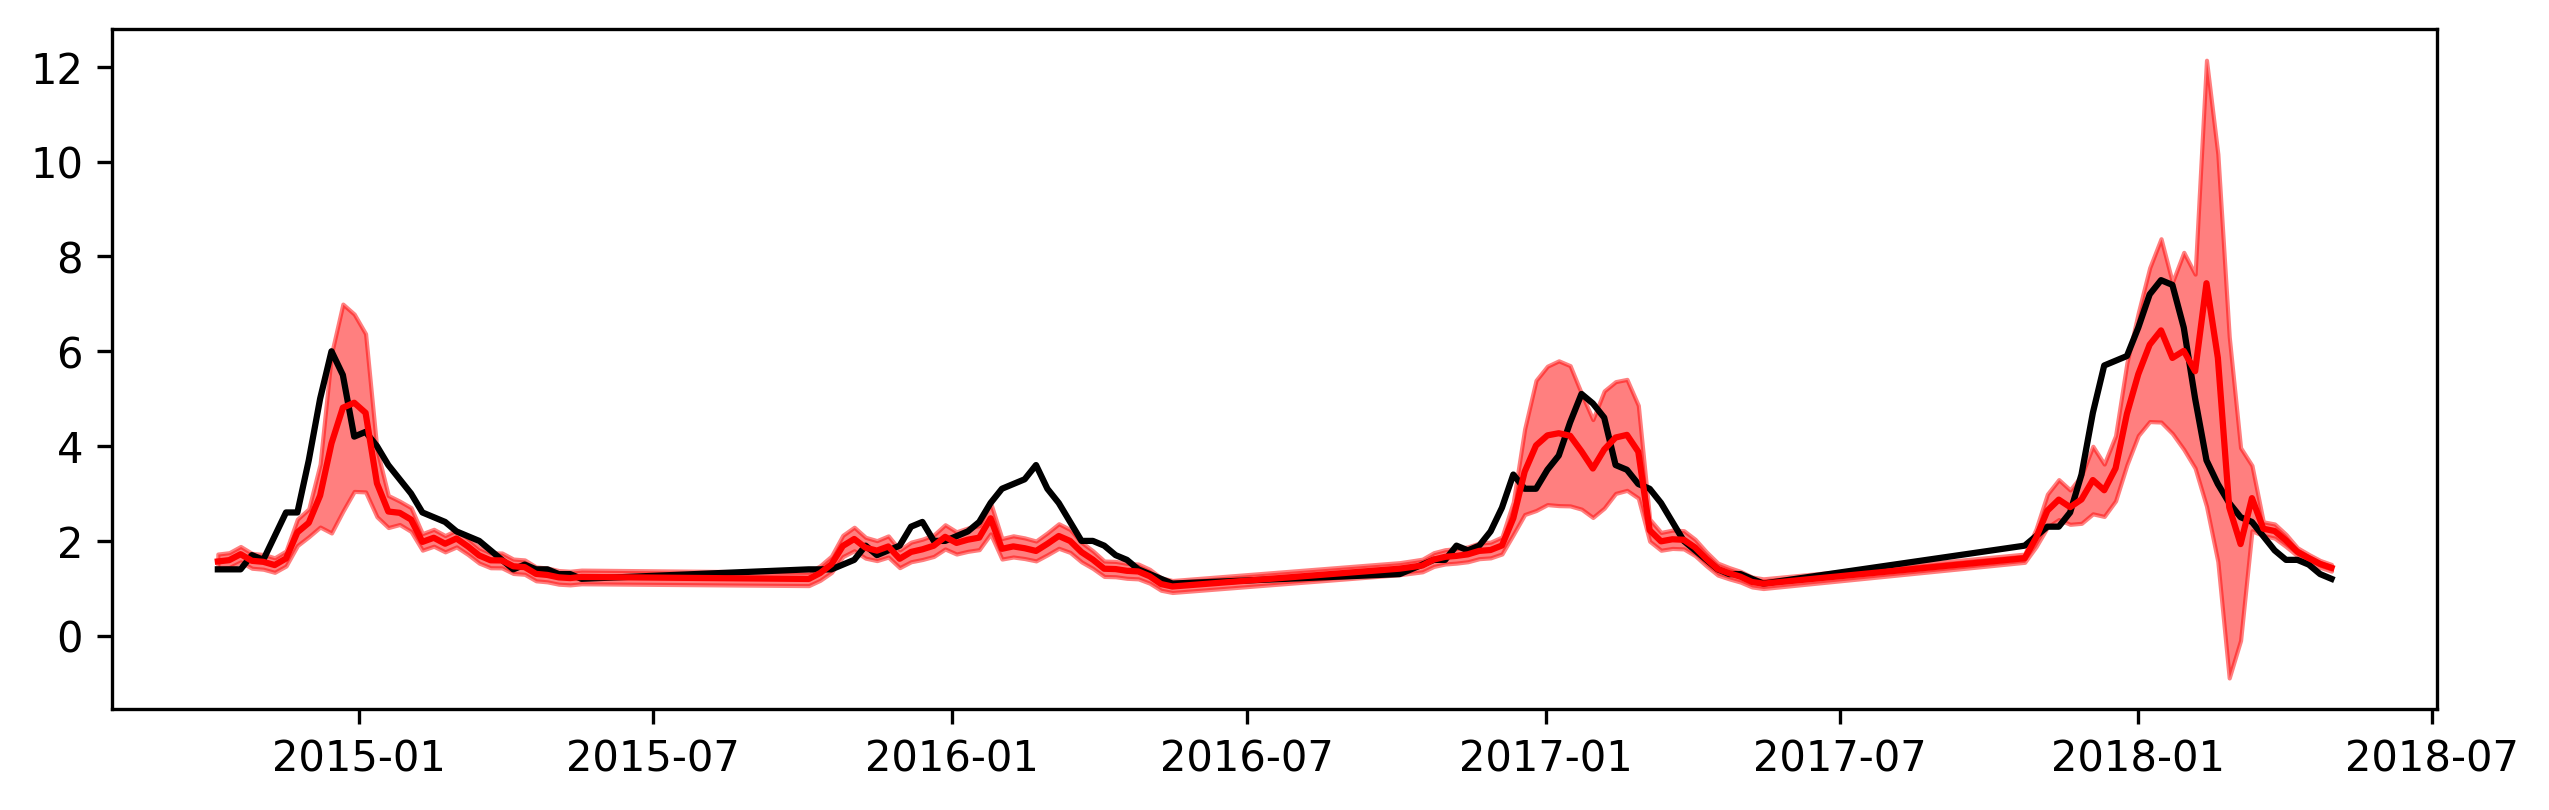

        2014/2015  2015/2016  2016/2017  2017/2018   Average
CRPS     0.373050   0.345778   0.290128   0.643717  0.413168
NLL      1.840789   3.462883   0.931507   2.118655  2.088458
MAE      0.479582   0.424295   0.396298   0.870750  0.542731
RMSE     0.687783   0.621355   0.556675   1.262696  0.782127
SMAPE    8.587089   9.841663   6.492946  10.817142  8.934710
Corr     0.892656   0.630617   0.886052   0.796659  0.801496
MB Log  -1.051880  -1.956789  -0.780362  -1.433310 -1.305585
SDP     -1.000000   0.000000  -1.000000   1.000000  0.250000


In [14]:
plt.figure(figsize=(10,3), dpi=300)
plt.plot(results.test_predictions['True'], color='black')
plt.plot(results.test_predictions['Pred'], color='red')
plt.fill_between(results.test_predictions.index, 
                 results.test_predictions['Pred']-results.test_predictions['Std'],
                 results.test_predictions['Pred']+results.test_predictions['Std'], color='red', alpha=0.5)

# plt.plot(y_test_full.index+dt.timedelta(days=14),
#          data.scaler.inverse_transform(np.tile(y_test_full.values, (255,1)).T)[:,-1],
#          '-.',color='green')
plt.show()
print(results.test_metrics)

In [78]:
for test_season in range(2014, 2018):
    print(test_season)

2014
2015
2016
2017


In [ ]:
optimizer.max


In [ ]:
results.val_metrics

val = [-0.282581, -0.278901, -0.633990, -0.420719, -0.686654]

test = [-1,        -0.590541, -0.526927, -0.264691, -0.686654]
val = [-0.717984, -0.900050, -0.735625, -0.781909, -0.627276]
for _ in val:
    print(np.exp(_))
# results.test_metrics

# theirs:
# NA    0.75
# 0.36  0.76
# 0.76  0.53
# 0.46  0.66
# 0.37  0.50

[-0.717984, -0.900050, -0.735625, -0.781909, -0.627276]

In [ ]:
results.val_metrics

In [ ]:
results.test_metrics

In [43]:
x_train, y_train, x_test, y_test = data.build(test_season=test_season, gamma=14, window_size=28)

In [45]:
y_test

,ILI
2014-10-06,0.142345
2014-10-13,0.142345
2014-10-20,0.142345
2014-10-27,0.183088
2014-11-03,0.169507
2014-11-10,0.237412
2014-11-17,0.305317
2014-11-24,0.305317
2014-12-01,0.454709
2014-12-08,0.631262


In [52]:
import importlib
import model
importlib.reload(model)

Batch_Size= 111.89539294177428
Epochs= 1
kl_anneal= 1.4663108094352386
lr= 0.0018672532085808908
num_layers= 2.2333003837753393
prior_scale= 1.182581715875808
rho_op= 6.881190569303937
rho_q= 4.432349490630539
scheduler_exp_val= -0.0443826297760547
scheduler_start_epoch= 184.17308048804264
sizeof_bnn= 52.69808183058956
sizeof_layers= 72.06818754442057

args = Namespace(Arch='FF', 
                 num_layers=int(num_layers),
                 sizeof_layers=int(sizeof_layers),
                 batch_norm=True,
                 Ext='-c', 
                 kl_anneal=float(kl_anneal),
                 rho_q=float(rho_q),
                 rho_op=float(rho_op),
                 prior_scale=float(prior_scale),
                 sizeof_bnn=int(sizeof_bnn),
                 Gamma=14, 
                 country='us', 
                 early_stopping=False, 
                 smooth=True,
                 scheduler_start_epoch=int(scheduler_start_epoch), 
                 lr=lr,
                 scheduler_exp_val=scheduler_exp_val,
                 Batch_Size=int(Batch_Size), 
                 Epochs=int(Epochs))
data = data_builder(root="/home/mimorris/Datasets/Flu/", 
                                country = args.country)

test_season=2014
tf.keras.backend.clear_session()
x_train, y_train, x_test, y_test = data.build(test_season=test_season, gamma=14, window_size=28)

NN = model.model_builder(x_train, y_train.values, args=args)
NN.fit(x_train, y_train.values, verbose=True)

import copy
a = copy.copy(x_test)

for idx, layer in enumerate(NN.model.layers[:3]):
    a = layer(a)
    print(layer, np.isnan(a.numpy()).sum())
    
layer.weights




36/36 [==============================] - ETA: 44s - Loss: 81283440.0000 - Likelihood: 81283424.0000 - KL: 6.49 - ETA: 0s - Loss: 1240479704.5333 - Likelihood: 1240479703.4667 - KL: 6.768 - ETA: 0s - Loss: 1188355811.7333 - Likelihood: 1188355811.2000 - KL: 6.774 - 1s 4ms/step - Loss: 1147802981.6216 - Likelihood: 1147802981.1892 - KL: 6.7807
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f1c04130880> 0
<tensorflow.python.keras.layers.core.Flatten object at 0x7f1c04130070> 0
<tensorflow.python.keras.layers.core.Dense object at 0x7f1c04130910> 0


[<tf.Variable 'dense/kernel:0' shape=(7140, 72) dtype=float32, numpy=
 array([[-0.00947582, -0.03306866,  0.00084521, ..., -0.01025806,
          0.0021778 , -0.00099359],
        [-0.02707447,  0.00399914,  0.00993871, ...,  0.01163271,
         -0.01346978, -0.01054041],
        [-0.01413061, -0.0279584 ,  0.00703371, ...,  0.02498547,
         -0.03363658, -0.0125222 ],
        ...,
        [-0.01189686,  0.03466192,  0.03113007, ...,  0.03511651,
         -0.01825141,  0.00494025],
        [ 0.01187472,  0.0274152 ,  0.038133  , ..., -0.01034631,
         -0.03683421, -0.01752632],
        [-0.00922081, -0.00630422, -0.02423378, ..., -0.01914568,
         -0.03056236, -0.00466873]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(72,) dtype=float32, numpy=
 array([-0.00872196,  0.01092367,  0.01779809, -0.02935069,  0.01092319,
         0.01232769,  0.00837062, -0.0127424 , -0.01092365,  0.00825747,
         0.01092365, -0.0119327 , -0.00808748,  0.00558255, -0.01092365,
     

In [55]:
rescale(NN.predict(x_test, y_test), data)

,True,Pred,Std
2014-10-06,1.4,-0.144843,13.242608
2014-10-13,1.4,-0.284124,14.632308
2014-10-20,1.4,-0.425706,16.029077
2014-10-27,1.7,-0.536745,16.716510
2014-11-03,1.6,-0.543248,16.490496
2014-11-10,2.1,-0.602429,16.091533
2014-11-17,2.6,-0.512110,15.628188
2014-11-24,2.6,-0.438848,15.882531
2014-12-01,3.7,-0.415896,16.362703
2014-12-08,5.0,-0.393894,17.487659


In [50]:
y_test

,ILI
2014-10-06,0.142345
2014-10-13,0.142345
2014-10-20,0.142345
2014-10-27,0.183088
2014-11-03,0.169507
2014-11-10,0.237412
2014-11-17,0.305317
2014-11-24,0.305317
2014-12-01,0.454709
2014-12-08,0.631262
